# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')

In [3]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

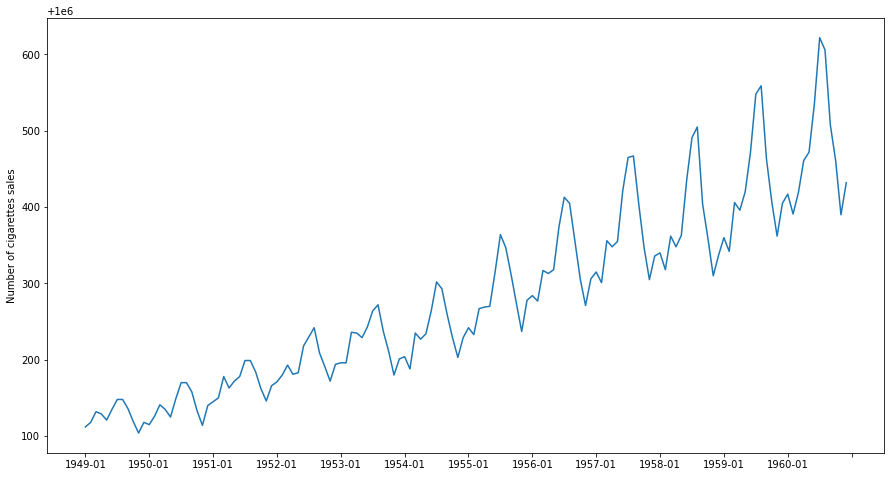

In [4]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

ax.plot(cigData['Time'], cigData['#CigSales'])

ax.xaxis.set_major_locator(ticker.MultipleLocator(12))

plt.ylabel('Number of cigarettes sales')
plt.show()

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.shape

(144, 3)

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData.drop('Unnamed: 0', axis=1, inplace=True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [9]:
cigData.rename({'Time': 'Month'}, axis='columns', inplace=True)

Call a head() to check this has worked. 

In [10]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [11]:
cigData['Month'] = pd.to_datetime(cigData['Month'], format='%Y-%m')

cigData.set_index('Month', inplace=True)

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [12]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [13]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [14]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

In [15]:
y.head()

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: #CigSales, dtype: int64

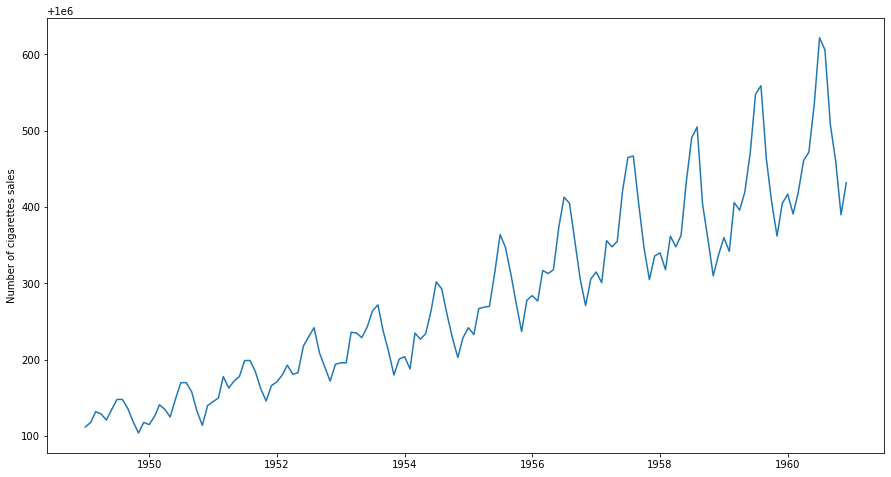

In [16]:
fig = plt.figure(figsize=(15,8))

plt.plot(y)

plt.ylabel('Number of cigarettes sales')

plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

**A**: This looks like a multiplicative model. The frequency of the cycles is constant (yearly) but the amplitude of the variations is increasing with time.

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

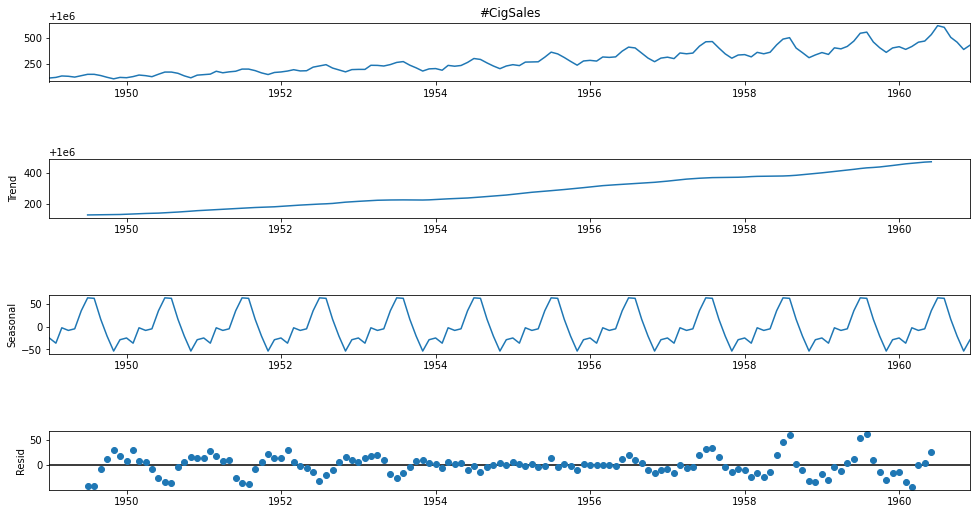

In [17]:
import statsmodels.api as sm

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = sm.tsa.seasonal_decompose(y, model='additive')

decomposition.plot()

fig = plt.gcf()

fig.set_size_inches(15, 8)

plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [18]:
from statsmodels.tsa.stattools import kpss

print(kpss(y, nlags='auto')[1])

0.01


/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

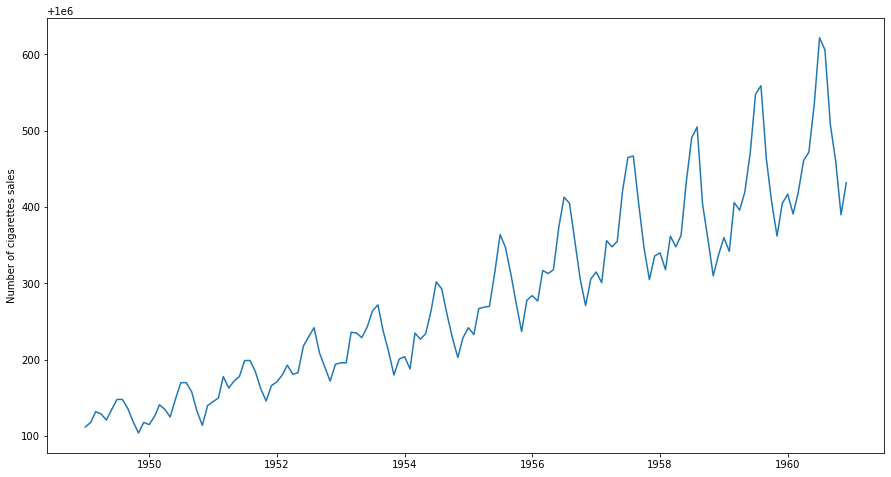

In [19]:
fig = plt.figure(figsize=(15,8))

plt.plot(y)

plt.ylabel('Number of cigarettes sales')

plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [20]:
# natural log is doesn't work with this data
y_diff12 = y.diff(12)


When you plot this, you can see how the variance in our data now remains contant over time.

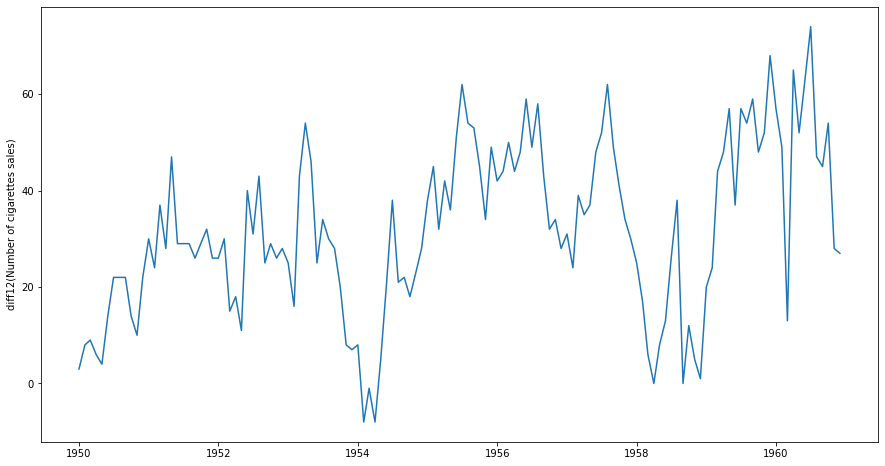

In [21]:
fig = plt.figure(figsize=(15,8))

plt.plot(y_diff12)

plt.ylabel('diff12(Number of cigarettes sales)')

plt.show()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [22]:
y_diff12_diff = y_diff12.diff()

In [23]:
y_diff12_diff.dropna(inplace=True)

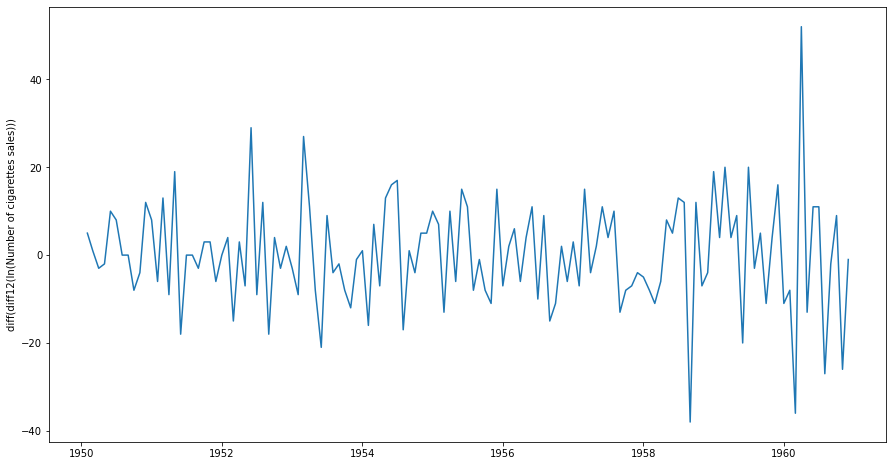

In [24]:
fig = plt.figure(figsize=(15,8))

plt.plot(y_diff12_diff)

plt.ylabel('diff(diff12(ln(Number of cigarettes sales)))')

plt.show()

In [25]:
print(kpss(y_diff12_diff, nlags='auto')[1])

0.1


/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [26]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [27]:
def arima_mse(y, trained_model):
    '''
    Mean squared error of a trained ARIMA model.
    '''
    y_pred = trained_model.predict()
    
    return mean_squared_error(y, y_pred)

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [28]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def score_arima(y, p, d, q):
    '''
    Calculate mean squared error for multiple ARIMA models, given the a time series `y`, and model parameters.
    
    Parameters
    ----------
    y : pandas.Series
        The time series.
    p: list of int
        Model's autoregresive parameter.
    d: list of int
        Model's differences parameter.
    q: list of int
        Model's moving average parameter.
    
    Returns
    -------
    mse: list of int
        Model's mean squared value.
    '''
    mse = []
    for p, d, q in zip(p,d,q):
        mod = ARIMA(y, order=(p, d, q))
        res = mod.fit()
        
        mse.append(arima_mse(y, res))
    
    return mse

In [29]:
# Now, we choose a couple of values to try for each parameter.
ps = [1,0,0,1,2,0,2,2,2]
ds = [0,0,1,1,0,0,0,1,1]
qs = [0,1,0,1,0,2,2,1,2]

In [30]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
mse_res = score_arima(y_diff12_diff, ps, ds, qs)

/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/pinto/mini

In [31]:
for (p,d,q,mse) in zip(ps,ds,qs,mse_res):
    print(f'Order: {p,d,q}, MSE: {mse:.2E}')

Order: (1, 0, 0), MSE: 1.37E+02
Order: (0, 0, 1), MSE: 1.37E+02
Order: (0, 1, 0), MSE: 3.97E+02
Order: (1, 1, 1), MSE: 1.40E+02
Order: (2, 0, 0), MSE: 1.37E+02
Order: (0, 0, 2), MSE: 1.37E+02
Order: (2, 0, 2), MSE: 1.27E+02
Order: (2, 1, 1), MSE: 1.40E+02
Order: (2, 1, 2), MSE: 1.35E+02


In [32]:
order_min_mse = np.argmin(mse_res)

In [33]:
ps[order_min_mse],ds[order_min_mse],qs[order_min_mse]

(2, 0, 2)

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

**A**: Model (2,0,2) has the lowest MSE, however, the when looking at the in-sample and forecast results, model (0,1,0) can't be beat. This is a random walk model.

In [34]:
mod = ARIMA(y_diff12_diff, order=(0,1,0))
res = mod.fit()

/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/pinto/miniconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


We can take a look at a summary of the model this library has built around our data.

In [35]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  131
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -573.875
Date:                Mon, 28 Dec 2020   AIC                           1149.749
Time:                        16:20:35   BIC                           1152.617
Sample:                    02-01-1950   HQIC                          1150.915
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       399.8120     32.667     12.239      0.000     335.786     463.838
===================================================================================
Ljung-Box (L1) (Q):                  57.11   Jarque-Bera (JB):                39.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                             0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [36]:
# y_pred = res.predict(start=0, end=len(y_diff12_diff))
y_pred = res.predict()

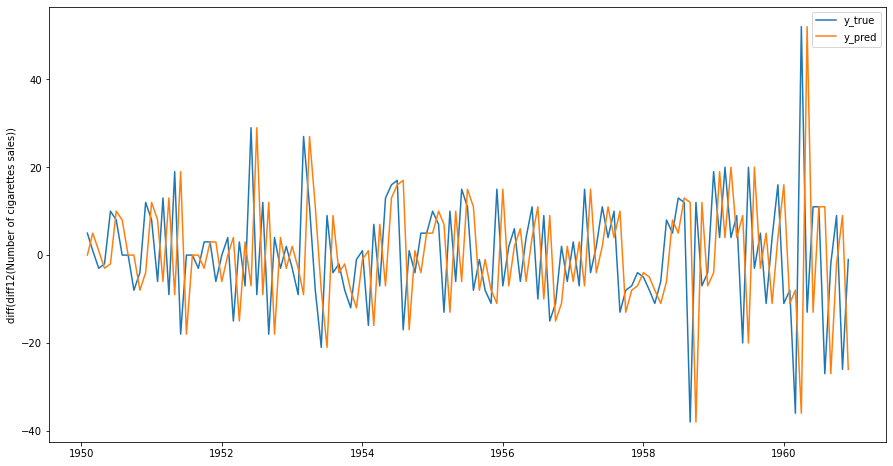

In [37]:
fig = plt.figure(figsize=(15,8))

plt.plot(y_diff12_diff, label='y_true')

plt.plot(y_pred, label='y_pred')

plt.ylabel('diff(diff12(Number of cigarettes sales))')

plt.legend()

plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [38]:
# Declare a variable called forecast_period with the amount of months to forecast, and
forecast_period = 24

# create a range of future dates that is the length of the periods you've chosen to forecast
start = y_diff12_diff.index[-1]
idx = pd.date_range(start, periods=forecast_period, freq='MS', name='Month')

# Convert that range into a dataframe that includes your predictions
end = idx[-1]
# y_pred_forecast = res.predict(start=start, end=end)
y_pred_forecast = res.forecast(forecast_period)

df = pd.DataFrame(y_pred_forecast, index=idx)

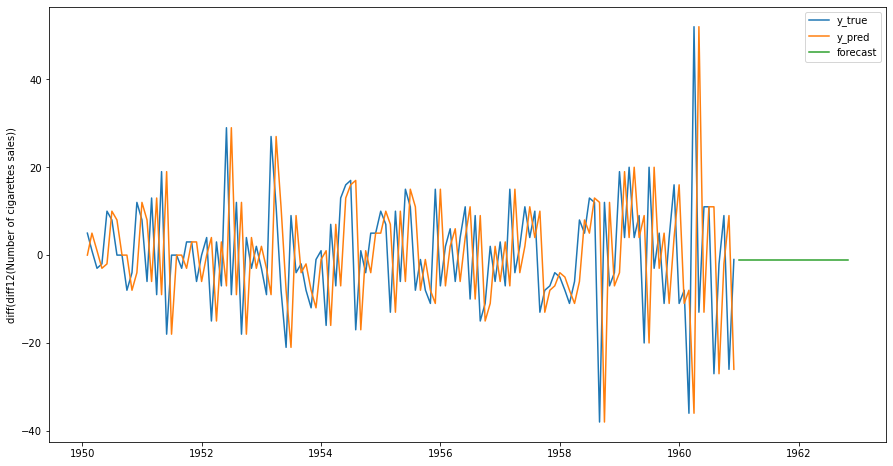

In [39]:
# Plot your future predictions
fig = plt.figure(figsize=(15,8))

plt.plot(y_diff12_diff, label='y_true')

plt.plot(y_pred, label='y_pred')

plt.plot(df, label='forecast')

plt.ylabel('diff(diff12(Number of cigarettes sales))')

plt.legend()

plt.show()

In [40]:
def diff_inv(original, diff, periods=1):
    '''
    Undo difference function.
    
    Parameters
    ----------
    original: pandas.Series
        The series that was differentiated.
    diff: pandas.Series
        The difference series.
    periods: int, optional
        The periods parameter used in differenciating the original series.
    
    Returns
    -------
    restored: pandas.DataFrame
        The restored values.
    
    Notes
    -------
    https://stackoverflow.com/questions/34918013/undo-a-series-diff
    '''    
    zero_pred_idx = diff.index[0]

    start_date = zero_pred_idx - pd.DateOffset(months=periods)
    end_date = diff.index[-1]
    freq_date = diff.index.freqstr

    restored_time_idx = pd.date_range(start=start_date, end=end_date, freq=freq_date, name='Month')

    restored = np.empty(len(restored_time_idx))
    restored[:] = np.nan

    restored = pd.Series(data=restored, index=restored_time_idx)

    head = original[start_date:zero_pred_idx]

    for idx, val in head.iteritems():
        restored[idx] = val

    for d, val in diff.iteritems():
        restored[d] = restored[d - pd.DateOffset(months=periods)] + val
    
    return restored

In [41]:
def restore_time_series(original, diff12, prediction):
    '''
    Restore time series after standardization.
    
    Parameters
    ----------
    original: pandas.Series
        The starting series.
    diff12: pandas.Series
        The differenciated series.
    prediction: pandas.Series
        The predicted series.
    
    Returns
    -------
    restored: pandas.DataFrame
        The restored values.
    
    Notes
    -------
    https://stackoverflow.com/questions/34918013/undo-a-series-diff
    '''
    back_y_pred_diff = diff_inv(diff12, prediction, periods=1)
    
    restored = diff_inv(original, back_y_pred_diff, periods=12)
    
    return restored

In [42]:
in_sample_pred = restore_time_series(y, y_diff12, y_pred)

In [43]:
forecast = restore_time_series(y, y_diff12, y_pred_forecast)

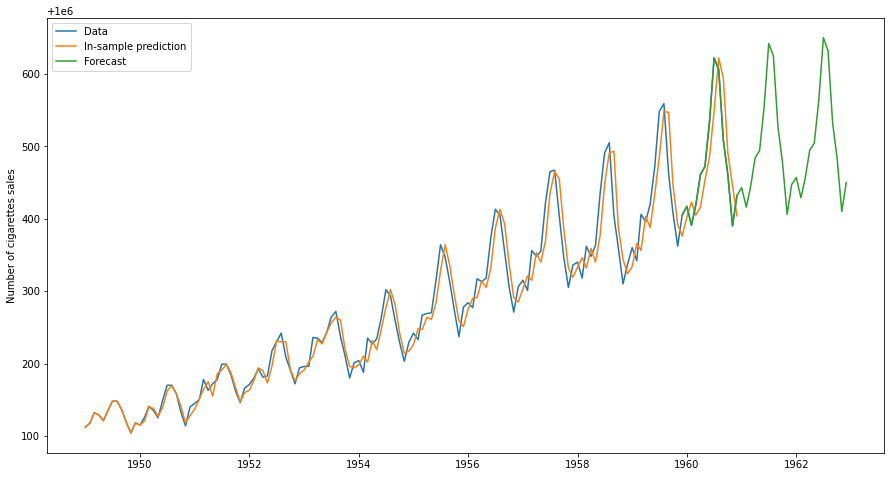

In [44]:
fig = plt.figure(figsize=(15,8))

plt.plot(y, label='Data')

plt.plot(in_sample_pred, label='In-sample prediction')

plt.plot(forecast, label='Forecast')

plt.ylabel('Number of cigarettes sales')

plt.legend()

plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 